In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# 定义衰减函数
def exp_decay(distance, beta):
    """计算指数衰减函数的值。"""
    return np.exp(-beta * distance)

def power_decay(distance, beta):
    """计算幂次衰减函数的值。"""
    return 1 / (1 + beta * distance)

# 定义计算平衡因子的函数
def calculate_balancing_factors(data, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                                cost_function, Ai_name, Bj_name, converge):
    """计算并迭代双约束空间交互模型的平衡因子。"""
    Oi = data[[orig_field, Oi_field]].copy()
    Dj = data[[dest_field, Dj_field]].copy()
    if cost_function.lower() == 'power':
        beta_cij = power_decay(data[cij_field], beta)
    elif cost_function.lower() == 'exponential':
        beta_cij = exp_decay(data[cij_field], beta)
    else:
        raise ValueError("成本函数设置错误，请使用 'power' 或 'exponential'")

    cnvg = 1
    iteration = 0
    while cnvg > converge:
        if iteration == 0:
            Oi[Ai_name] = 1.0 / (Dj[Dj_field] * beta_cij).groupby(data[orig_field]).transform('sum')
            Dj[Bj_name] = 1.0 / (Oi[Oi_field] * Oi[Ai_name] * beta_cij).groupby(data[dest_field]).transform('sum')
        else:
            Oi_new = 1.0 / (Dj[Bj_name] * Dj[Dj_field] * beta_cij).groupby(data[orig_field]).transform('sum')
            Dj_new = 1.0 / (Oi[Oi_field] * Oi_new * beta_cij).groupby(data[dest_field]).transform('sum')
            cnvg = max((Oi_new - Oi[Ai_name]).abs().sum(), (Dj_new - Dj[Bj_name]).abs().sum())
            Oi[Ai_name] = Oi_new
            Dj[Bj_name] = Dj_new
        iteration += 1

    data[Ai_name] = Oi[Ai_name]
    data[Bj_name] = Dj[Bj_name]
    return data

# 定义预测交通流量的函数
def predict_traffic(data, Oi_field, Dj_field, Ai_field, Bj_name, cij_field, beta):
    """使用更新的权重因子预测交通流量。"""
    decay_values = exp_decay(data[cij_field], beta)
    print("Decay values sample:", decay_values.head())  # 打印衰减函数的一些输出值
    data['predicted_flow'] = data[Oi_field] * data[Ai_field] * data[Dj_field] * data[Bj_name] * exp_decay(data[cij_field], beta)
    return data

# 优化β值
def objective_function(beta, data, orig_field, dest_field, Oi_field, Dj_field, cij_field, cost_function, Ai_name, Bj_name, converge):
    """计算预测流量和实际流量之间的均方误差。"""
    temp_data = calculate_balancing_factors(
        data=data.copy(),
        orig_field=orig_field,
        dest_field=dest_field,
        Oi_field=Oi_field,
        Dj_field=Dj_field,
        cij_field=cij_field,
        beta=beta,
        cost_function=cost_function,
        Ai_name=Ai_name,
        Bj_name=Bj_name,
        converge=converge
    )
    temp_data = predict_traffic(temp_data, Oi_field, Dj_field, Ai_name, Bj_name, cij_field, beta)
    mse = ((temp_data['predicted_flow'] - temp_data['flows']) ** 2).mean()
    return mse

# 主程序
try:
    data = pd.read_csv('london_flows_forP2.csv')
    if 'flows' not in data.columns:
        raise ValueError("缺少必要的 'actual_flows' 列。")

    initial_beta = [0.003]
    result = minimize(
        objective_function,
        initial_beta,
        args=(data, 'station_origin', 'station_destination', 'population', 'jobs', 'distance', 'exponential', 'A_factor', 'B_factor', 0.001),
        method='L-BFGS-B',
        bounds=[(0.00000001, 1.5)]
    )
    print("最优化的β值:", result.x)

    # 使用最优化的β重新计算平衡因子和预测流量
    optimized_beta = result.x[0]
    optimized_data = calculate_balancing_factors(
        data=data,
        orig_field='station_origin',
        dest_field='station_destination',
        Oi_field='population',
        Dj_field='jobs',
        cij_field='distance',
        beta=optimized_beta,
        cost_function='exponential',
        Ai_name='A_factor',
        Bj_name='B_factor',
        converge=0.001
    )
    optimized_data = predict_traffic(optimized_data, 'population', 'jobs', 'A_factor', 'B_factor', 'distance', optimized_beta)
    print(optimized_data.head())
    optimized_data.to_csv('optimized_london_flows_exponential.csv', index=False)
except Exception as e:
    print(f"运行过程中发生错误: {e}")


Decay values sample: 0    1.039104e-05
1    1.377525e-06
2    2.544313e-11
3    2.455725e-15
4    3.275315e-06
Name: distance, dtype: float64
Decay values sample: 0    1.039064e-05
1    1.377463e-06
2    2.544106e-11
3    2.455449e-15
4    3.275177e-06
Name: distance, dtype: float64
Decay values sample: 0    0.999962
1    0.999955
2    0.999919
3    0.999888
4    0.999958
Name: distance, dtype: float64
Decay values sample: 0    0.999924
1    0.999910
2    0.999837
3    0.999776
4    0.999916
Name: distance, dtype: float64
Decay values sample: 0    4.456961e-03
1    1.718058e-03
2    1.004452e-05
3    1.281186e-07
4    2.585197e-03
Name: distance, dtype: float64
Decay values sample: 0    4.456791e-03
1    1.717981e-03
2    1.004370e-05
3    1.281042e-07
4    2.585088e-03
Name: distance, dtype: float64
Decay values sample: 0    0.522682
1    0.466251
2    0.251757
3    0.149262
4    0.489652
Name: distance, dtype: float64
Decay values sample: 0    0.522662
1    0.466230
2    0.251737
3  

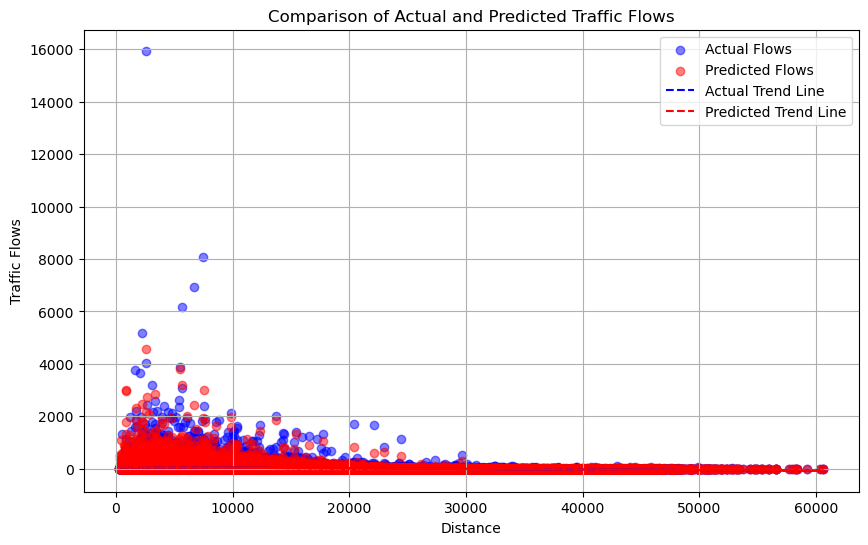

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 加载数据
data = pd.read_csv('optimized_london_flows_exponential.csv')  # 确保文件路径和文件名正确

# 绘制实际流量与预测流量的对比图
plt.figure(figsize=(10, 6))

# 绘制实际流量点
plt.scatter(data['distance'], data['flows'], color='blue', label='Actual Flows', alpha=0.5)
# 绘制预测流量点
plt.scatter(data['distance'], data['predicted_flow'], color='red', label='Predicted Flows', alpha=0.5)

# 添加实际流量趋势线
z_actual = np.polyfit(data['distance'], data['flows'], 1)
p_actual = np.poly1d(z_actual)
plt.plot(data['distance'], p_actual(data['distance']), "b--", label='Actual Trend Line')

# 添加预测流量趋势线
z_predicted = np.polyfit(data['distance'], data['predicted_flow'], 1)
p_predicted = np.poly1d(z_predicted)
plt.plot(data['distance'], p_predicted(data['distance']), "r--", label='Predicted Trend Line')

plt.title('Comparison of Actual and Predicted Traffic Flows')
plt.xlabel('Distance')
plt.ylabel('Traffic Flows')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# 加载数据
data_exponential = pd.read_csv('optimized_london_flows_exponential.csv')  # 指数型衰减结果文件
data_power = pd.read_csv('optimized_london_flows_power.csv')  # 幂次型衰减结果文件

# 计算指数型衰减的MSE和R^2
mse_exp = mean_squared_error(data_exponential['flows'], data_exponential['predicted_flow'])
r2_exp = r2_score(data_exponential['flows'], data_exponential['predicted_flow'])

# 计算幂次型衰减的MSE和R^2
mse_power = mean_squared_error(data_power['flows'], data_power['predicted_flow'])
r2_power = r2_score(data_power['flows'], data_power['predicted_flow'])

# 打印结果
print("指数型衰减函数预测结果:")
print("MSE:", mse_exp)
print("R^2:", r2_exp)

print("\n幂次型衰减函数预测结果:")
print("MSE:", mse_power)
print("R^2:", r2_power)

# 比较两个模型的表现
if mse_exp < mse_power:
    print("\nThe exponential decay model has a lower MSE and performs better.")
else:
    print("\nThe power-type decays model has a lower MSE and performs better.")

if r2_exp > r2_power:
    print("The exponential decay model has a higher R^2 and performs better.")
else:
    print("The power-type decays model has a higher R^2 and performs better.")


指数型衰减函数预测结果:
MSE: 8721.013617205665
R^2: 0.4955050294258655

幂次型衰减函数预测结果:
MSE: 9567.850704104892
R^2: 0.44651702527994364

The exponential decay model has a lower MSE and performs better.
The exponential decay model has a higher R^2 and performs better.


In [4]:
##Scenario A

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# 定义衰减函数
def exp_decay(distance, beta):
    """计算指数衰减函数的值。"""
    return np.exp(-beta * distance)


# 定义计算平衡因子的函数
def calculate_balancing_factors(data, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                                cost_function, Ai_name, Bj_name, converge, epsilon=1e-10):
    """计算并迭代双约束空间交互模型的平衡因子。"""
    Oi = data[[orig_field, Oi_field]].copy()
    Dj = data[[dest_field, Dj_field]].copy()
    
    if cost_function.lower() == 'power':
        beta_cij = power_decay(data[cij_field], beta)
    elif cost_function.lower() == 'exponential':
        beta_cij = exp_decay(data[cij_field], beta)
    else:
        raise ValueError("成本函数设置错误，请使用 'power' 或 'exponential'")

    cnvg = 1
    iteration = 0
    while cnvg > converge:
        sum_O = (Dj[Dj_field] * beta_cij).groupby(data[orig_field]).transform('sum') + epsilon
        sum_D = (Oi[Oi_field] * beta_cij).groupby(data[dest_field]).transform('sum') + epsilon
        
        if iteration == 0:
            Oi[Ai_name] = 1.0 / sum_O
            Dj[Bj_name] = 1.0 / sum_D
        else:
            Oi_new = 1.0 / ((Dj[Bj_name] * Dj[Dj_field] * beta_cij).groupby(data[orig_field]).transform('sum') + epsilon)
            Dj_new = 1.0 / ((Oi[Oi_field] * Oi_new * beta_cij).groupby(data[dest_field]).transform('sum') + epsilon)
            cnvg = max((Oi_new - Oi[Ai_name]).abs().sum(), (Dj_new - Dj[Bj_name]).abs().sum())
            Oi[Ai_name] = Oi_new
            Dj[Bj_name] = Dj_new
        iteration += 1

    data[Ai_name] = Oi[Ai_name]
    data[Bj_name] = Dj[Bj_name]
    return data

# 定义预测交通流量的函数
def predict_traffic(data, Oi_field, Dj_field, Ai_field, Bj_name, cij_field, beta):
    """使用更新的权重因子预测交通流量。"""
    decay_values = exp_decay(data[cij_field], beta)
    print("Decay values sample:", decay_values.head())  # 打印衰减函数的一些输出值
    data['predicted_flow'] = data[Oi_field] * data[Ai_field] * data[Dj_field] * data[Bj_name] * exp_decay(data[cij_field], beta)
    return data

# 优化β值
def objective_function(beta, data, orig_field, dest_field, Oi_field, Dj_field, cij_field, cost_function, Ai_name, Bj_name, converge):
    """计算预测流量和实际流量之间的均方误差。"""
    temp_data = calculate_balancing_factors(
        data=data.copy(),
        orig_field=orig_field,
        dest_field=dest_field,
        Oi_field=Oi_field,
        Dj_field=Dj_field,
        cij_field=cij_field,
        beta=beta,
        cost_function=cost_function,
        Ai_name=Ai_name,
        Bj_name=Bj_name,
        converge=converge
    )
    temp_data = predict_traffic(temp_data, Oi_field, Dj_field, Ai_name, Bj_name, cij_field, beta)
    mse = ((temp_data['predicted_flow'] - temp_data['flows']) ** 2).mean()
    return mse

# 主程序
try:
    data = pd.read_csv('london_flows_forSA.csv')
    if 'flows' not in data.columns:
        raise ValueError("缺少必要的 'actual_flows' 列。")

    initial_beta = [0.003]
    result = minimize(
        objective_function,
        initial_beta,
        args=(data, 'station_origin', 'station_destination', 'population', 'jobs', 'distance', 'exponential', 'A_factor', 'B_factor', 0.001),
        method='L-BFGS-B',
        bounds=[(0.00000001, 1.5)]
    )
    print("最优化的β值:", result.x)

    # 使用最优化的β重新计算平衡因子和预测流量
    optimized_beta = 0.00015769
    optimized_data = calculate_balancing_factors(
        data=data,
        orig_field='station_origin',
        dest_field='station_destination',
        Oi_field='population',
        Dj_field='jobs',
        cij_field='distance',
        beta=optimized_beta,
        cost_function='exponential',
        Ai_name='A_factor',
        Bj_name='B_factor',
        converge=0.001
    )
    optimized_data = predict_traffic(optimized_data, 'population', 'jobs', 'A_factor', 'B_factor', 'distance', optimized_beta)
    print(optimized_data.head())optimized_data.to_csv('optimized_london_flows_exponential.csv', index=False)
except Exception as e:
    print("An error occurred:", e)



In [ ]:
optimized_data.to_csv('optimized_london_flows_v1.csv', index=False)

In [ ]:
# 检查新旧总通勤人数是否一致，调整平衡因子直至满足条件
original_total_flows = data['flows'].sum()
new_total_flows = optimized_data['predicted_flow'].sum()

# 如果总流量有差异，调整Ai和Bj直到满足总流量不变的条件
while abs(new_total_flows - original_total_flows) > 100:  # 容忍度设置为1，可根据实际需要调整
    adjustment_factor = original_total_flows / new_total_flows
    optimized_data['A_factor'] *= adjustment_factor  # 调整A因子
    optimized_data = predict_traffic(optimized_data, 'population', 'jobs', 'A_factor', 'B_factor', 'distance', optimized_beta)
    new_total_flows = optimized_data['predicted_flow'].sum()

# 保存新的流量数据
optimized_data.to_csv('adjusted_london_flows_v1.csv', index=False)


In [ ]:
import pandas as pd

data_50 = pd.read_csv('london_flows_forP2.csv')

# 使用最优化的β重新计算平衡因子和预测流量
try:
    optimized_beta = 0.00023654
    optimized_data = calculate_balancing_factors(
        data=data_50,
        orig_field='station_origin',
        dest_field='station_destination',
        Oi_field='population',
        Dj_field='jobs',
        cij_field='distance',
        beta=optimized_beta,
        cost_function='exponential',
        Ai_name='A_factor',
        Bj_name='B_factor',
        converge=0.001
    )
    optimized_data = predict_traffic(optimized_data, 'population', 'jobs', 'A_factor', 'B_factor', 'distance', optimized_beta)
    print(optimized_data.head())
    optimized_data.to_csv('adjusted_london_flows_v2.csv', index=False)
except Exception as e:
    print("An error occurred:", e)


In [ ]:
import pandas as pd

data_100 = pd.read_csv('london_flows_forP2.csv')

# 使用最优化的β重新计算平衡因子和预测流量
try:
    optimized_beta = 0.00028384
    optimized_data = calculate_balancing_factors(
        data=data_100,
        orig_field='station_origin',
        dest_field='station_destination',
        Oi_field='population',
        Dj_field='jobs',
        cij_field='distance',
        beta=optimized_beta,
        cost_function='exponential',
        Ai_name='A_factor',
        Bj_name='B_factor',
        converge=0.001
    )
    optimized_data = predict_traffic(optimized_data, 'population', 'jobs', 'A_factor', 'B_factor', 'distance', optimized_beta)
    print(optimized_data.head())
    optimized_data.to_csv('adjusted_london_flows_v3.csv', index=False)
except Exception as e:
    print("An error occurred:", e)
